# Bug 1744320: performance analysis of Rust minidump-stackwalk

Bug 1437708 covers switching from Breakpad stackwalker to Rust minidump-stackwalk. We've been running Rust minidump-stackwalk in the Socorro stage environment for over a week.

This covers analysis of performance timings and metrics for the week of 2021-11-29 through 2021-12-05.

Socorro has two server environments: stage and prod. The stage environment processes 10% of the crash reports from prod.

For the week in question, we had the following number of crash reports:

**Environment** | **Count**
--------------- | ---------
stage | 69,807
prod | 923,940

(Note: stage doesn't have 10% of prod because stage also throttles incoming crash reports, so only 10% of Firefox Windows release channel crash reports are accepted by stage of the 10% that prod is submitting.)

That should be enough timings to hand-wave some rough numbers from.

In [1]:
import datetime
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Timing

In prod, the `BreakpadStackwalkerRule2015` processor rule runs Breakpad `stackwalker` on the minidump.

In stage, the `MinidumpStackwalkerRule` processor rule runs rust-minidump `minidump-stackwalk` on the minidump.

We capture timings for both rules using statsd timing which is sent to influxdb and queried with Grafana Explore interface.

3019.4082337984037
7161.307409928936


(0.0, 10000.0)

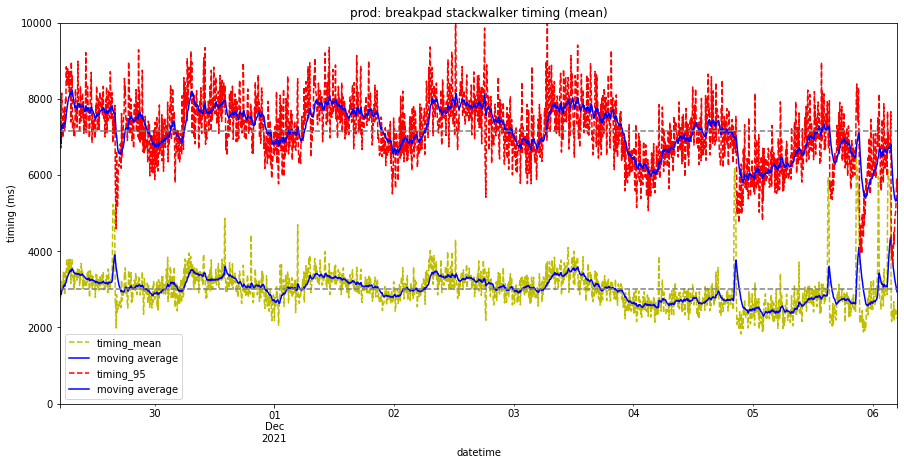

In [2]:
plt.figure()

data = pd.read_csv("./bug_1744320_data/breakpad_timings_mean.csv")
data["datetime"] = pd.to_datetime(data["Time"], unit="ms", utc=True)
data["timing_mean"] = pd.to_numeric(data["processor.rule.act.timing.mean"])

mean_timing_mean = data["timing_mean"].mean()
print(mean_timing_mean)

input_data = data[["datetime", "timing_mean"]]
input_data.set_index("datetime", inplace=True)

df = input_data["timing_mean"]
df.plot(style="y--", xlabel="datetime", ylabel="timing (ms)", figsize=(15, 7))
df.ewm(span=24).mean().plot(style="b", label="moving average")


data_95 = pd.read_csv("./bug_1744320_data/breakpad_timings_95.csv")
data["datetime"] = pd.to_datetime(data_95["Time"], unit="ms", utc=True)
data["timing_95"] = pd.to_numeric(data_95["processor.rule.act.timing.mean"])

n95_timing_mean = data["timing_95"].mean()
print(n95_timing_mean)

input_data_95 = data[["datetime", "timing_95"]]
input_data_95.set_index("datetime", inplace=True)

df_95 = input_data_95["timing_95"]
df_95.plot(style="r--", xlabel="datetime", ylabel="timing (ms)", figsize=(15, 7))
df_95.ewm(span=24).mean().plot(style="b", label="moving average")

plt.legend()
plt.axhline(y=mean_timing_mean, linestyle="--", color="gray")
plt.axhline(y=n95_timing_mean, linestyle="--", color="gray")
plt.title("prod: breakpad stackwalker timing (mean)")
plt.xlabel("datetime")
plt.ylabel("timing (ms)")
plt.ylim(0, 10000)

2939.140226540436
8171.666259592243


(0.0, 10000.0)

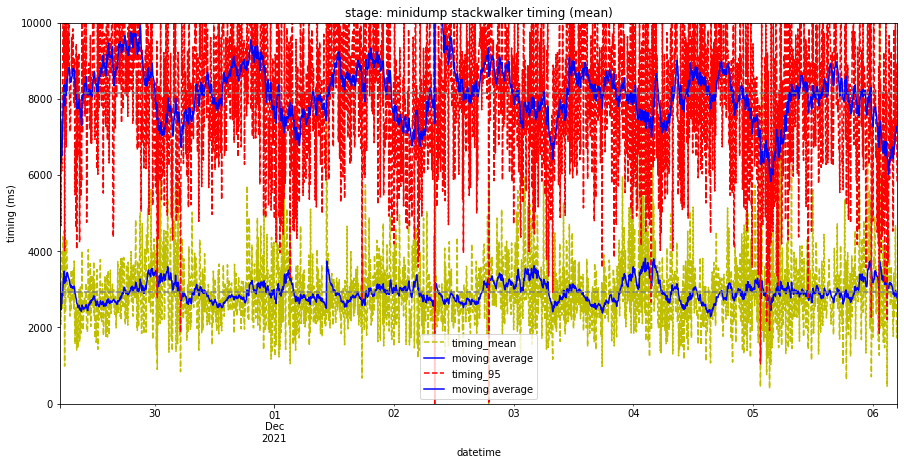

In [3]:
plt.figure()

data = pd.read_csv("./bug_1744320_data/minidump_timings_mean.csv")
data["datetime"] = pd.to_datetime(data["Time"], unit="ms", utc=True)
data["timing_mean"] = pd.to_numeric(data["processor.rule.act.timing.mean"])

mean_timing_mean = data["timing_mean"].mean()
print(mean_timing_mean)

input_data = data[["datetime", "timing_mean"]]
input_data.set_index("datetime", inplace=True)

df = input_data["timing_mean"]
df.plot(style="y--", xlabel="datetime", ylabel="timing (ms)", figsize=(15, 7))
df.ewm(span=24).mean().plot(style="b", label="moving average")

data_95 = pd.read_csv("./bug_1744320_data/minidump_timings_95.csv")
data["datetime"] = pd.to_datetime(data_95["Time"], unit="ms", utc=True)
data["timing_95"] = pd.to_numeric(data_95["processor.rule.act.timing.mean"])

n95_timing_mean = data["timing_95"].mean()
print(n95_timing_mean)

input_data_95 = data[["datetime", "timing_95"]]
input_data_95.set_index("datetime", inplace=True)

df_95 = input_data_95["timing_95"]
df_95.plot(style="r--", xlabel="datetime", ylabel="timing (ms)", figsize=(15, 7))
df_95.ewm(span=24).mean().plot(style="b", label="moving average")

plt.legend()
plt.axhline(y=mean_timing_mean, linestyle="--", color="gray")
plt.axhline(y=n95_timing_mean, linestyle="--", color="gray")
plt.title("stage: minidump stackwalker timing (mean)")
plt.xlabel("datetime")
plt.ylabel("timing (ms)")
plt.ylim(0, 10000)

The minidump stackwalk graph feels more erratic than the breakpad graph does. The mean numbers are roughly the same, but the 95% number for Rust minidump-stackwalk are worse than Breakpad stackwalker:

field | rust minidump-stackwalk | breakpad stackwalker
--- | --- | ---
mean | 2939 | 3019
95% | 8171 | 7161

The deploy pipeline deploys a new stage environment every code change. Both stackwalkers use a disk cache for downloaded symbols files. Every time we deploy an environment, that wipes out the disk caches. The 95% timings in the stage environment are affected by this.

The stage environment has a single processor node. That node runs a single processor process which spins off multiple threads for processing crash reports. Because there's a single processor node, it's likely that crash reports that take a long time to process take an even longer time on stage on average.

Do we see the same thing if we look at timings between the stackwalkers on specific crash reports?

We don't capture a timing for the stackwalker rules in a way that lets us see timings for specific crash reports. However, stackwalking is the bulk of the time it takes to process a crash report, so we can use `started_datetime` and `completed_datetime`. They are the datestamps marking the begin and end of processing a specific crash report and are stored as metadata in the processed crash. We can use that as a proxy for how long stackwalking took for that crash.

Let's look at 100 crash reports from 2021-12-01 for Firefox that all have minidumps.

stage mean (s): 2.86
prod mean (s): 4.3


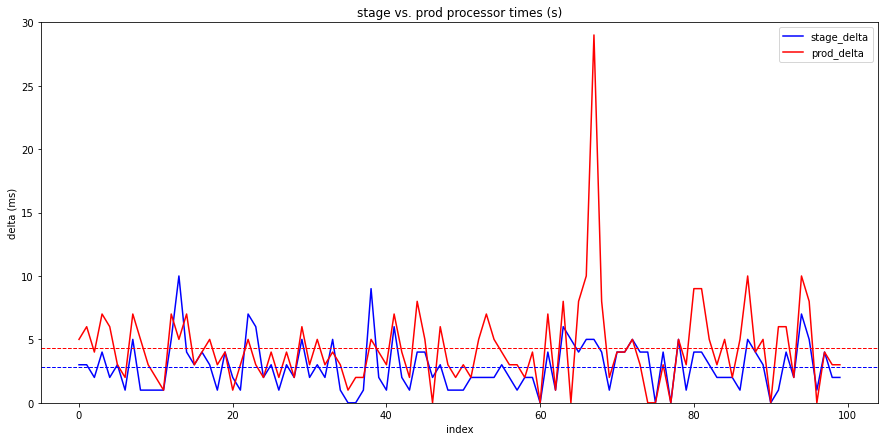

In [4]:
plt.figure()

data = pd.read_csv("./bug_1744320_data/processor_times.csv")
data["stage_delta"] = pd.to_numeric(data["stage_delta"])
data["prod_delta"] = pd.to_numeric(data["prod_delta"])

input_data = data[["index", "stage_delta", "prod_delta"]]
input_data.set_index("index", inplace=True)

stage_delta_mean = data["stage_delta"].mean()
prod_delta_mean = data["prod_delta"].mean()

df_stage = input_data["stage_delta"]
df_stage.plot(style="b-", xlabel="stage", ylabel="delta (s)", figsize=(15, 7))

df_prod = input_data["prod_delta"]
df_prod.plot(style="r-", xlabel="prod", ylabel="delta (s)", figsize=(15, 7))

plt.legend()
plt.title("stage vs. prod processor times (s)")
plt.axhline(y=stage_delta_mean, linestyle="--", linewidth=1, color="blue", label="stage mean")
plt.axhline(y=prod_delta_mean, linestyle="--", linewidth=1, color="red", label="prod mean")
plt.xlabel("index")
plt.ylabel("delta (ms)")
plt.ylim(0, 30)

print(f"stage mean (s): {stage_delta_mean}")
print(f"prod mean (s): {prod_delta_mean}")

Looking at processing times between stage and prod for specific crashes suggests stage processes crashes faster than prod most of the time.

This data suggests that Rust minidump-stackwalk processes minidumps faster on average than Breakpad stackwalker.

## Processor CPU usage and memory usage

In production, the number of processors scale up and down based on load. In stage, the number of processors doesn't scale at all--it's static at 1.

Because of this, I don't think it makes sense to compare CPU usage or memory usage between stage and prod.

However, we can look at mean memory and cpu usage on stage to see if there are any red flags.

(0.0, 100.0)

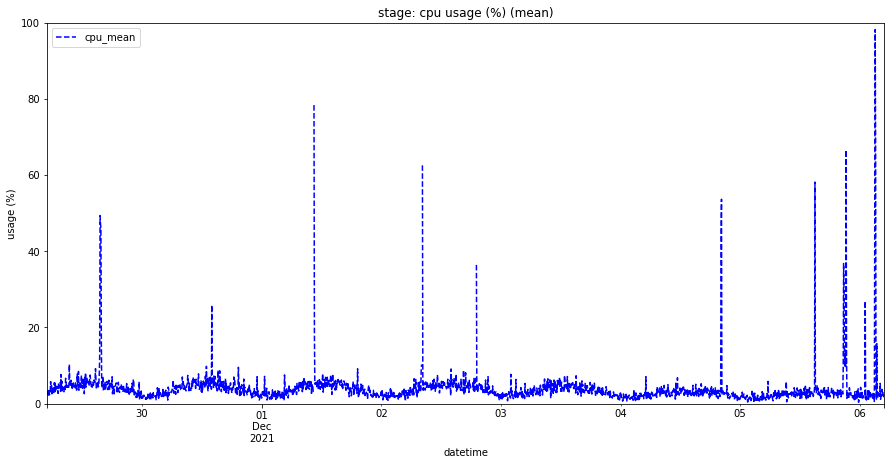

In [5]:
plt.figure()

data = pd.read_csv("./bug_1744320_data/minidump_cpu_mean.csv")
data["datetime"] = pd.to_datetime(data["Time"], unit="ms", utc=True)
data["cpu_mean"] = pd.to_numeric(data["cpu.mean"])

input_data = data[["datetime", "cpu_mean"]]
input_data.set_index("datetime", inplace=True)

df = input_data["cpu_mean"]
df.plot(style="b--", xlabel="datetime", ylabel="percent", figsize=(15, 7))

plt.legend()
plt.title("stage: cpu usage (%) (mean)")
plt.xlabel("datetime")
plt.ylabel("usage (%)")
plt.ylim(0, 100)

This seems fine to me.

(0.0, 100.0)

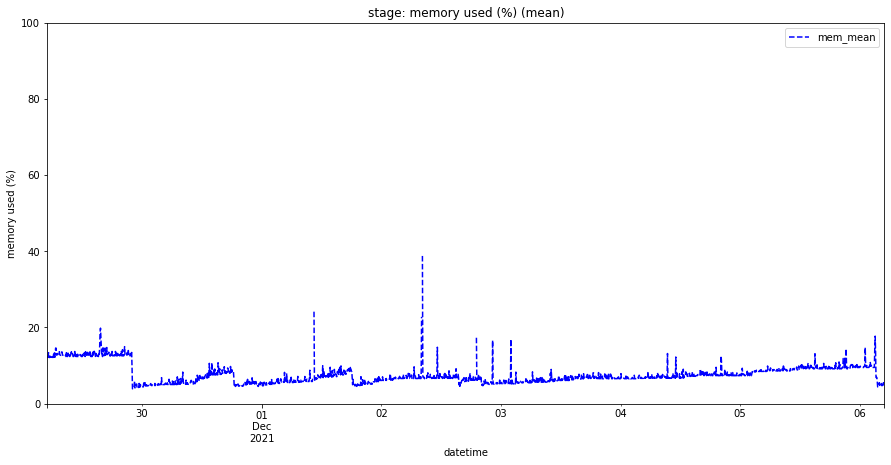

In [6]:
plt.figure()

data = pd.read_csv("./bug_1744320_data/minidump_memory_mean.csv")
data["datetime"] = pd.to_datetime(data["Time"], unit="ms", utc=True)
data["mem_mean"] = pd.to_numeric(data["mem.mean"])

input_data = data[["datetime", "mem_mean"]]
input_data.set_index("datetime", inplace=True)

df = input_data["mem_mean"]
df.plot(style="b--", xlabel="datetime", ylabel="percent", figsize=(15, 7))

plt.legend()
plt.title("stage: memory used (%) (mean)")
plt.xlabel("datetime")
plt.ylabel("memory used (%)")
plt.ylim(0, 100)

Note the steps. Every drop is a stage deploy.

We run both stackwalkers as separate processes, so once they finish running, the process ends and all memory is recovered. The memory usage here is predominantly the Python part of the processor which hasn't changed.

This seems fine to me.

# Conclusion

We looked at timing performance between Breakpad stackwalker and Rust minidump-stackwalk by looking at timings between stage and prod environments over the same period of time. While stage looks more erratic and the 95% timings are worse, it's definitely the case that Rust minidump-stackwalk is not a significant regression.

We looked at processing times for specific crash reports between stage and prod environments. While processing times include other work the processor does other than stackwalking, stackwalking does account for the bulk of the time. This data suggests that Rust minidump-stackwalk processes minidumps faster than Breakpad stackwalker does for most crash reports.

We can't compare stage and prod to understand differences in performance for CPU usage or memory usage, but we can look at the same period of time on stage for red flags. I don't see any red flags.